In [ ]:
#ifif using colab
! pip install hmmlearn
! pip install yfinance

     |████████████████████████████████| 374 kB 4.3 MB/s 
     |████████████████████████████████| 6.3 MB 6.0 MB/s 
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


# Packages and Data Split

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
#from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.regime_switching.markov_autoregression import MarkovAutoregression
import numpy as np
from hmmlearn import hmm
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
aapl = yf.download("AAPL", start="2010-01-01", end="2021-10-31").reset_index()
aapl.Date = pd.to_datetime(aapl.Date)

[*********************100%***********************]  1 of 1 completed


In [ ]:
daily_return = aapl['Return'] = aapl.Close.pct_change().dropna()

#(np.log(aapl.Close /aapl.Close.shift(-1))).dropna()
# np.log(aapl.Close.pct_change()).dropna()

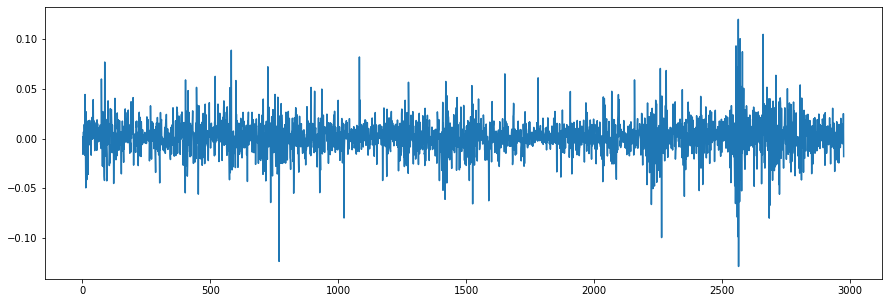

In [ ]:
plt.plot(daily_return)

# HMM 

In [ ]:
# train,test = aapl[aapl.Date<'2021-01-01'],aapl[aapl.Date>='2021-01-01']
train,test = daily_return[:2800],daily_return[2800:]

In [ ]:
train_np = np.array(train).reshape(-1,1)
test_np = np.array(test).reshape(-1,1)

In [ ]:
remodel = hmm.GaussianHMM(n_components=3, covariance_type="full", n_iter=1000)
remodel.fit(train_np)

GaussianHMM(covariance_type='full', n_components=3, n_iter=1000)

In [ ]:
plot_data = train_np
predict_state = remodel.predict(plot_data)

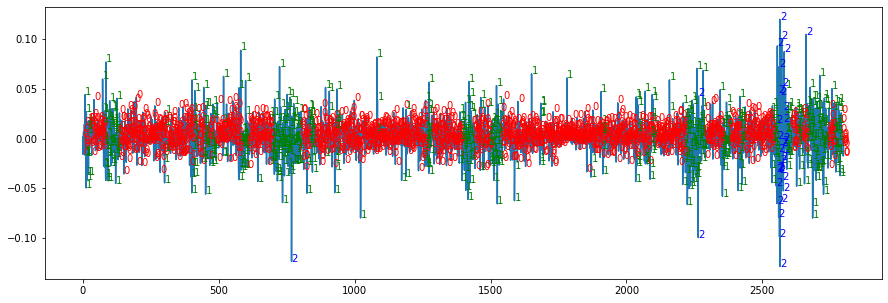

In [ ]:
plt.rcParams["figure.figsize"] = (15,5)
plt.plot(plot_data)
color_set = ['r','g','b']
for i, txt in enumerate(predict_state):
    plt.annotate(int(txt), (i, plot_data[i]),c=color_set[int(txt)])

In [ ]:
hmm_prediction = remodel.sample(len(test_np),random_state = predict_state[-1])
hmm_prediction_value = hmm_prediction[0]
hmm_prediction_states = hmm_prediction[1]

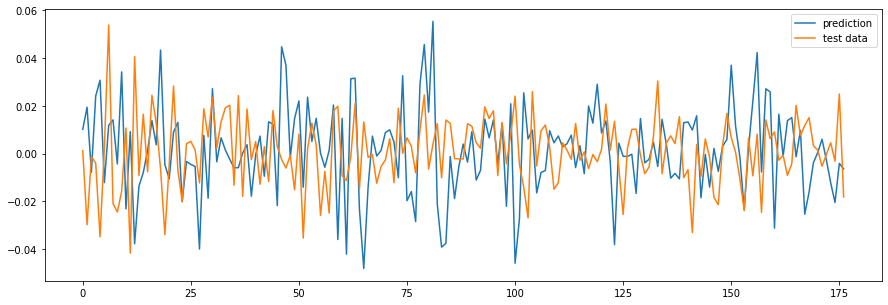

In [ ]:
plt.plot(hmm_prediction_value,label = 'prediction')
plt.plot(test_np, label = 'test data')
plt.legend()

In [ ]:
mean_absolute_percentage_error(test_np,hmm_prediction_value)

5.517757327394471

In [ ]:
mean_squared_error(test_np,hmm_prediction_value)

0.0008351536941600156

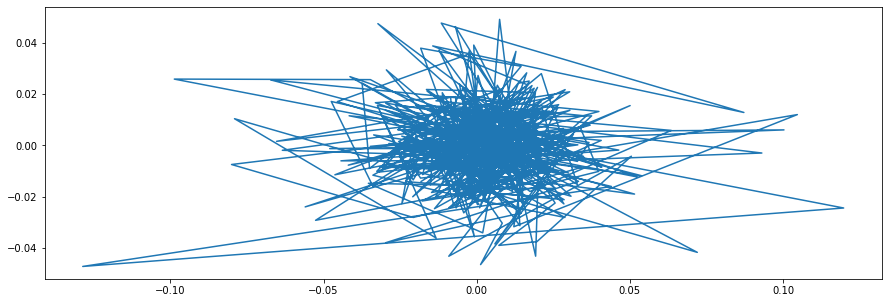

In [ ]:
plt.plot(test_np,hmm_prediction_value)

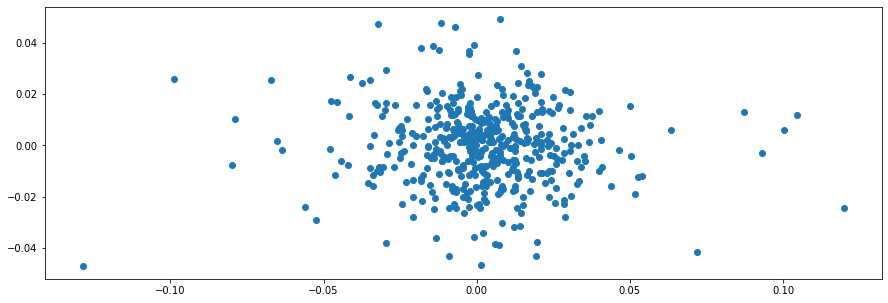

In [ ]:
plt.scatter(test_np,hmm_prediction_value)

# markov_autoregression

In [ ]:
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

In [ ]:
adfuller(daily_return)

(-11.237407413760499,
 1.8426727255304894e-20,
 21,
 2955,
 {'1%': -3.432564886510389,
  '5%': -2.862518591340487,
  '10%': -2.567290930826469},
 -15461.41543827477)

In [ ]:
mod_kns = sm.tsa.MarkovRegression(daily_return.dropna(), k_regimes=3, trend='nc', switching_variance=True)
res_kns = mod_kns.fit()
res_kns.summary()

C:\Users\xiezi\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\xiezi\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                  Close   No. Observations:                 2977
Model:               MarkovRegression   Log Likelihood                8130.922
Date:                Fri, 19 Nov 2021   AIC                         -16243.843
Time:                        17:36:17   BIC                         -16189.855
Sample:                             0   HQIC                        -16224.416
                               - 2977                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      7.453e-05   9.79e-06      7.609      0.000    5.53e-05    9.37e-05
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0002   3.37e-05      6.875      0.000       0.000       0.000
                             Regime 2 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0012      0.000      5.446      0.000       0.001       0.002
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9286      0.021     44.646      0.000       0.888       0.969
p[1->0]        0.0346      0.019      1.842      0.066      -0.002       0.071
p[2->0]        0.0089      0.022      0.403      0.687      -0.034       0.052
p[0->1]        0.0558      0.028      2.021      0.043       0.002       0.110
p[1->1]        0.9281      0.026     35.104      0.000       0.876       0.980
p[2->1]        0.1888      0.088      2.137      0.033       0.016       0.362
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [ ]:
mod_kns.start_params

array([3.33333333e-01, 3.33333333e-01, 3.33333333e-01, 3.33333333e-01,
       3.33333333e-01, 3.33333333e-01, 3.13034916e-05, 1.72169204e-04,
       3.13034916e-04])

In [ ]:
mod_kns.param_names

['p[0->0]',
 'p[1->0]',
 'p[2->0]',
 'p[0->1]',
 'p[1->1]',
 'p[2->1]',
 'sigma2[0]',
 'sigma2[1]',
 'sigma2[2]']

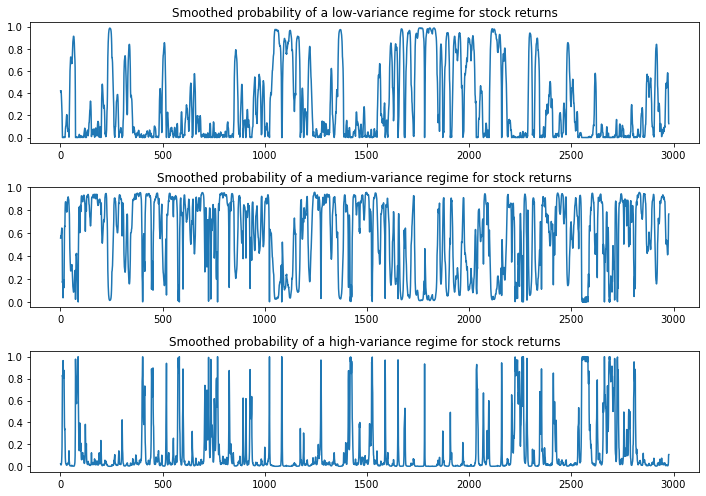

In [ ]:
fig, axes = plt.subplots(3, figsize=(10,7))
ax = axes[0]
ax.plot(res_kns.smoothed_marginal_probabilities[0])
ax.set(title='Smoothed probability of a low-variance regime for stock returns')
ax = axes[1]
ax.plot(res_kns.smoothed_marginal_probabilities[1])
ax.set(title='Smoothed probability of a medium-variance regime for stock returns')
ax = axes[2]
ax.plot(res_kns.smoothed_marginal_probabilities[2])
ax.set(title='Smoothed probability of a high-variance regime for stock returns')
fig.tight_layout()

# ARIMA Prediction

In [ ]:
model = ARIMA(train['Close'],order = (5,2,2))

In [ ]:
model_fit = model.fit()

0         0.000000
1         7.166997
2         4.754135
3         4.208190
4         3.550584
           ...    
2642    646.559323
2643    663.811205
2644    665.351023
2645    670.617720
2646    695.919844
Length: 2647, dtype: float64

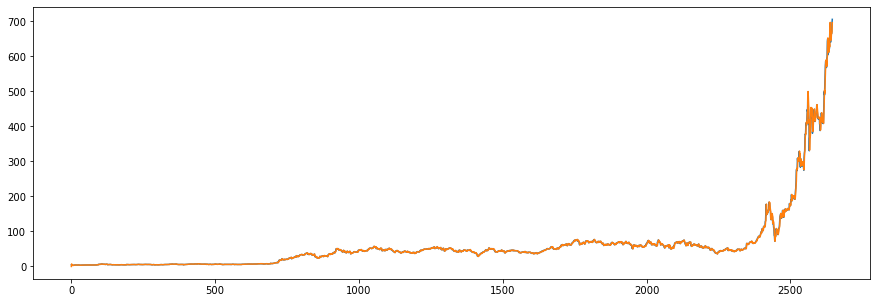

In [ ]:
plt.plot(train_np)
plt.plot(model_fit.predict())

In [ ]:
model_refit = model.update(test.Close)

In [ ]:
model_refit

array([ 729.77001953,  735.10998535,  755.97998047,  816.03997803,
        880.02001953,  811.19000244,  849.44000244,  854.40997314,
        845.        ,  826.15997314,  844.54998779,  850.45001221,
        844.98999023,  846.64001465,  880.79998779,  883.09002686,
        864.15997314,  835.42999268,  793.5300293 ,  839.80999756,
        872.78997803,  854.69000244,  849.98999023,  852.22998047,
        863.41998291,  849.46002197,  804.82000732,  811.65997314,
        816.11999512,  796.2199707 ,  798.15002441,  787.38000488,
        781.29998779,  714.5       ,  698.84002686,  742.02001953,
        682.2199707 ,  675.5       ,  718.42999268,  686.44000244,
        653.20001221,  621.44000244,  597.95001221,  563.        ,
        673.58001709,  668.05999756,  699.59997559,  693.72998047,
        707.94000244,  676.88000488,  701.80999756,  653.15997314,
        654.86999512,  670.        ,  662.15997314,  630.27001953,
        640.39001465,  618.71002197,  611.28997803,  635.61999

In [ ]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2647
Model:                 ARIMA(5, 2, 2)   Log Likelihood               -8048.679
Date:                Thu, 18 Nov 2021   AIC                          16113.358
Time:                        16:31:26   BIC                          16160.402
Sample:                             0   HQIC                         16130.389
                               - 2647                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9447      0.031    -30.219      0.000      -1.006      -0.883
ar.L2         -0.0360      0.007     -5.029      0.000      -0.050      -0.022
ar.L3          0.0514      0.006      8.140      0.0

In [ ]:
print(model_refit.summary())

AttributeError: 'numpy.ndarray' object has no attribute 'summary'

In [ ]:
model_fit.forecast(len(test))

2769    133.039942
2770    133.535988
2771    133.380505
2772    133.842607
2773    133.753033
           ...    
2973    174.194465
2974    174.395966
2975    174.597466
2976    174.798967
2977    175.000467
Length: 209, dtype: float64

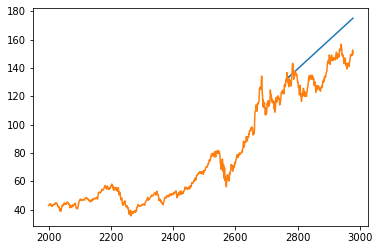

In [ ]:
plt.plot(model_fit.forecast(len(test),alpha = 0.05))
plt.plot(aapl[2000:].Close)